In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


In [2]:
%matplotlib inline

### 1.数据处理

In [3]:
yjcj_data=pd.read_csv('./学生成绩记录/汕头大学工学院成绩登记表-计算机硬件基础.csv',skiprows=4)

yjcj_data=yjcj_data.drop(["Unnamed: 8"],axis=1)#成绩表导入
if np.any(pd.isnull(yjcj_data))==True:#如果导入有空缺值，则去除
    yjcj_data=yjcj_data.dropna()
    
yjwj_data=pd.read_csv('./计算机硬件基础-课程调查/问卷汇总.csv',skiprows=2)#问卷表导入
yjwj_mz=yjwj_data.iloc[:,0:1]
yjwj_jh=yjwj_data.iloc[:,3:64:2]
yjwj_data = pd.merge(yjwj_mz,yjwj_jh,left_index=True,right_index=True)#将问卷中学习前的数据删去
if np.any(pd.isnull(yjcj_data))==True:
    for i in yjwj_data.columns:
        if np.any(pd.isnull(yjwj_data[i]))==True:
            yjwj_data[i].fillna(yjwj_data[i].mean(),inplace=True) #将问卷表中NAN的数值变为该列的平均值
sum_lie=(yjwj_data.sum(axis=1)/(31*5))*100 #在问卷表中添加一列学习掌握数据
yjwj_data["sum"]=sum_lie

cols=['学号','姓名','77','作业总分(30%)','实践总分(20%)']#x1
x1=yjcj_data[cols]
cols=['姓名','考试成绩']#y
y=yjcj_data[cols]
cols=['Unnamed: 0','sum']#x2
x2=yjwj_data[cols]
x2.columns=['姓名','sum']#将x2改名使得可以连接

data = pd.merge(x1,x2)#将x1,x2拼接起来
data.columns=['学号','姓名','专业','作业总分','实践总分','问卷sum']
data = pd.merge(data,y)#将x1，x2，y拼接在一起


#将差距特别大的数据删除（作业成绩与实践成绩都与考试成绩相差20分以上的）
if np.any(data[(data['作业总分']-data['考试成绩']>20)&(data['实践总分']-data['考试成绩']>20)])==True:
    for i in yjwj_data.index:#在df的列名表中循环
        if (data['作业总分'][i]-data['考试成绩'][i]>20) and (data['实践总分'][i]-data['考试成绩'][i]>20)==True:
            print(i)
            data.drop(data.index[[i]],inplace=True)

data.head()

42


C:\Users\Administrator\AppData\Local\Temp/ipykernel_29236/3824098349.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sum_lie=(yjwj_data.sum(axis=1)/(31*5))*100 #在问卷表中添加一列学习掌握数据


,学号,姓名,专业,作业总分,实践总分,问卷sum,考试成绩
0,2.020612e+09,陈绮琪,数据科学与大数据技术(2020),61.875,80.0,81.290323,73.0
1,2.020612e+09,陈掌航,数据科学与大数据技术(2020),70.625,70.0,67.096774,81.0
2,2.020612e+09,程景培,数据科学与大数据技术(2020),88.750,75.0,80.645161,79.0
3,2.020612e+09,戴子晨,数据科学与大数据技术(2020),87.500,85.0,78.064516,77.0
4,2.020612e+09,董宸廷,数据科学与大数据技术(2020),72.500,85.0,65.806452,70.0


###  2.使用不同方法

####  2.1.直接拟合

In [4]:
from sklearn.linear_model import LinearRegression
def direct_line():
    acc=[]
    coef=[]
    cols=['作业总分','实践总分','问卷sum']
    estimator=LinearRegression()
    for i in range(10):
        x_train,x_test,y_train,y_test=train_test_split(data[cols],data['考试成绩'],test_size=0.2,random_state=22)
        estimator.fit(x_train,y_train)
        coef.append(estimator.coef_)

        y_pred=estimator.predict(x_test)
        acc.append(sum(abs(y_pred-y_test)<10)/len(y_test))
        
    print("\n系数是:\n",np.mean(coef))
    print("测试集直接拟合的精确度:\n",np.mean(acc))
    return np.mean(acc)

####  2.2.SGD梯度下降

In [5]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
def SGD_line():
    acc=[]
    coef=[]
    intercept=[]
    cols=['作业总分','实践总分','问卷sum']
    for i in range(10):
            #数据预处理
        x_train,x_test,y_train,y_test=train_test_split(data[cols],data['考试成绩'],test_size=0.2,random_state=22)    
        transfer=StandardScaler()

        x_train_std=transfer.fit_transform(x_train)
        y_train_std=(y_train-np.mean(y_train))/np.std(y_train)

        x_test_std=transfer.fit_transform(x_test)

        estimator=SGDRegressor(loss="squared_loss",fit_intercept=True,learning_rate='invscaling',eta0=0.01)
        #fit_intercept,设置偏置，防止过拟合，eta0，学习速率
        estimator.fit(x_train_std,y_train_std)

        coef.append(estimator.coef_)


        intercept.append(estimator.intercept_)

        y_pred=estimator.predict(x_test_std)
        y_pred=y_pred*np.std(y_test)+np.mean(y_test)
        acc.append(sum(abs(y_pred-y_test)<10)/len(y_test))

    print("\n系数是:\n",np.mean(coef) ) 
    print("偏置是:\n",np.mean(intercept))
    print("测试集SGD梯度下降拟合的精确度:\n",np.mean(acc))
    return np.mean(acc)

####  2.3.决策树

In [6]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
def decision_tree():
    acc=[]
    max_acc=0
    cols=['作业总分','实践总分','问卷sum']
    for i in range(10):
        x_train,x_test,y_train,y_test=train_test_split(data[cols],data['考试成绩'],test_size=0.2,random_state=22)
        estimator=DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state=None)
        estimator.fit(x_train,y_train)

        #预测

        y_pred=estimator.predict(x_test)
        acc_now=sum(abs(y_pred-y_test)<10)/len(y_test)
        acc.append(acc_now)
        if acc_now>max_acc:
            max_acc=acc_now
            export_graphviz(estimator,'./tree_jisuan.dot')
        
    print("\n测试集决策树精确度:\n",np.mean(acc))
    return np.mean(acc)

####  2.4.集成学习

In [7]:
from sklearn.ensemble import AdaBoostClassifier
def integrated_learning():
    acc=[]
    cols=['作业总分','实践总分','问卷sum']
    for i in range(10):
        x_train,x_test,y_train,y_test=train_test_split(data[cols],data['考试成绩'],test_size=0.2,random_state=22)
        estimator=DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state=None)
        estimator=AdaBoostClassifier(base_estimator=estimator,n_estimators=15, learning_rate=0.01, algorithm='SAMME.R')
        estimator.fit(x_train,y_train)

        #预测
        y_pred=estimator.predict(x_test)
        acc.append(sum(abs(y_pred-y_test)<10)/len(y_test))

    print("\n测试集boosting精确度:\n",np.mean(acc))
    return np.mean(acc)

#### 2.5.LSTM

In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
max_index=0
def LSTM():
    
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    writer = SummaryWriter(log_dir='logs')
    input_size=1

    class RNN(nn.Module):
        def __init__(self,input_size):
            super(RNN,self).__init__()
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=64,
                num_layers=1,
                batch_first=True
            )
            self.out = nn.Sequential(
                nn.Linear(64,1)
            )

        def forward(self, x):
            r_out,(h_n,h_c) = self.rnn(x,None)  # None 表示 hidden state 会用全0的 state
            out = self.out(r_out)
            return out



    class mytrainset(Dataset):
        def __init__(self, data):        
            self.data,self.label = data[:,:-1].float(),data[:,-1].float()

        def __getitem__(self, index):
            return self.data[index],self.label[index]

        def __len__(self):
            return len(self.data)


    train_data=pd.merge(x_train,y_train,left_index=True,right_index=True)

    train_numpy=np.array(train_data)
    train_mean=np.mean(train_numpy)
    train_std=np.std(train_numpy)
    train_numpy=(train_numpy-train_mean)/train_std
    train_sentor=torch.Tensor(train_numpy)

    trainset = mytrainset(train_sentor)
    trainloader = DataLoader(trainset,batch_size=30,shuffle=True)
    
    test_data=pd.merge(x_test,y_test,left_index=True,right_index=True)

    test_numpy=np.array(test_data)
    test_data_size=len(test_data)
    test_mean=np.mean(test_numpy)
    test_std=np.std(test_numpy)
    test_numpy=(test_numpy-test_mean)/test_std
    test_sentor=torch.Tensor(test_numpy)

    testset = mytrainset(test_sentor)
    test_dataloader = DataLoader(testset,batch_size=5,shuffle=True)
    
    rnn =RNN(3)
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)  
    loss_func = nn.MSELoss()
    test_time=0
    train_batch_size=10
    acc=0
    for step in range(101):
        for tx, ty in trainloader:
            #在第1个维度上添加一个维度为1的维度，形状变为[batch,seq_len,input_size]
            output = rnn(torch.unsqueeze(tx, dim=0)) 
            loss = loss_func(torch.squeeze(output), ty)#将output维度为0的维度去掉
            optimizer.zero_grad()  
            loss.backward()  
            optimizer.step()
        writer.add_scalar('训练loss', loss, step) 
        if step%10==0:
          print("训练轮数:{}".format(step))  
          print("loss:{}".format(loss.item()))

        true_time=0
        test_batch_size=5
        xiaofencha=0
        for tx,ty in test_dataloader:
          output=rnn(torch.unsqueeze(tx,dim=1))#unsqueeze(tx,dim=1)在tx的1处增加一个维度
          output=output[:,-1,:]
          output=output.detach().numpy()
          output=output*test_std+test_mean
          ty=np.array(ty)
          ty=ty.reshape(-1,1)
          ty=ty*test_std+test_mean
          end=ty-output

          for i in range(0,len(end)):  
            if(abs(end[i])<10):
              xiaofencha=xiaofencha+1 
          writer.add_scalar('测试精确度',xiaofencha/len(end), step)     
        if step%10==0:    
          print("精确度:{}\n".format(xiaofencha/len(end))) 
        if step>80:
            if (xiaofencha/len(end))>acc:
                max_index=step
                acc=xiaofencha/len(end)
                #torch.save(rnn,"第{}轮模型".format(step))        

    writer.close()
    %reload_ext tensorboard
    from tensorboard import notebook
    %tensorboard --logdir ./logs/ --port=1598
    return acc

####  2.6.相关系数

In [9]:
from scipy.stats import spearmanr
def relate():
    ##斯皮尔曼相关系数
    #useful_data=pd.merge(data[cols],data['考试成绩'],left_index=True,right_index=True)
    for i in data[cols].columns:
        print("{}与考试成绩的斯皮尔曼相关性:\n".format(i),spearmanr(data[i],data['考试成绩']))

###  3.数据集划分

In [10]:
cols=['作业总分','实践总分','问卷sum']
x_train,x_test,y_train,y_test=train_test_split(data[cols],data['考试成绩'],test_size=0.2,random_state=22)

### 4.实现各类方法并返回准确率

In [11]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
acc_list=[]
title_list=['直接拟合','SGD梯度下降','决策树','集成学习','LSTM']
acc_list.append(direct_line())
acc_list.append(SGD_line())
acc_list.append(decision_tree())
acc_list.append(integrated_learning())
acc_list.append(LSTM())




系数是:
 0.25466313296110066
测试集直接拟合的精确度:
 0.33333333333333337

系数是:
 0.23710659990062535
偏置是:
 -0.0019875880057644442
测试集SGD梯度下降拟合的精确度:
 0.4444444444444445

测试集决策树精确度:
 0.4888888888888888

测试集boosting精确度:
 0.3333333333333333
训练轮数:0
loss:1.1062666177749634
精确度:1.0

训练轮数:10
loss:0.7915529608726501
精确度:1.0

训练轮数:20
loss:0.6932389140129089
精确度:1.0

训练轮数:30
loss:0.7404801845550537
精确度:1.0

训练轮数:40
loss:0.5719538927078247
精确度:1.0

训练轮数:50
loss:0.07051917165517807
精确度:1.0

训练轮数:60
loss:0.20933322608470917
精确度:1.0

训练轮数:70
loss:0.23794223368167877
精确度:1.0

训练轮数:80
loss:0.14085887372493744
精确度:1.0

训练轮数:90
loss:0.5664653182029724
精确度:1.0

训练轮数:100
loss:0.15626415610313416
精确度:1.0



Reusing TensorBoard on port 1598 (pid 26140), started 2 days, 18:48:48 ago. (Use '!kill 26140' to kill it.)

###  5.画图数据比较与分析

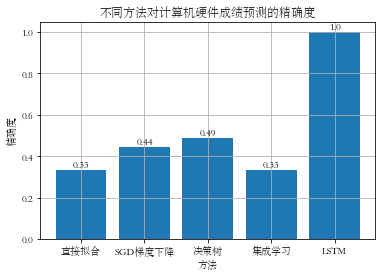

In [12]:
plt.rcParams['font.family']='STsong'# 显示汉字 SimHei黑体，STsong 华文宋体还有font.style  font.size等
plt.rcParams['axes.unicode_minus'] = False

plt.grid(True)
plt.bar(title_list,acc_list)
for a,b in zip(title_list, acc_list):
    plt.text(a,b,
             round(b,2),
             ha='center', 
             va='bottom',
            )
plt.title('不同方法对计算机硬件成绩预测的精确度')
plt.xlabel('方法')
plt.ylabel('精确度') 
plt.show()

In [13]:
relate()

作业总分与考试成绩的斯皮尔曼相关性:
 SpearmanrResult(correlation=0.2446899969017263, pvalue=0.11834377922872874)
实践总分与考试成绩的斯皮尔曼相关性:
 SpearmanrResult(correlation=0.2766965850094176, pvalue=0.07608010760907107)
问卷sum与考试成绩的斯皮尔曼相关性:
 SpearmanrResult(correlation=0.1966222609597908, pvalue=0.2120207626056959)
